## Alunos

- Arthur Vieira toscano da Silva - 20210094400
- Antonio Rocha Lima Filho - 20200008122
- Andre Lopes de Sousa e Oliveira - 20210066881

## Projeto de treinamento de um detector de Fake News

In [ ]:
!pip install tensorflow keras keras-hub
!pip install -q gdown

ERROR: Operation cancelled by user
ERROR: Operation cancelled by user


# Download dataset

- Pegamos o seguinte dataset: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset/data

In [ ]:
import kagglehub
import shutil
import os

# Baixa o dataset
path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")

print("Caminho original dos arquivos:", path)

# Copia os arquivos do dataset para o diretório principal (/content)
for filename in os.listdir(path):
    src = os.path.join(path, filename)
    dst = os.path.join("/content", filename)
    shutil.copy(src, dst)

print("Arquivos copiados para /content")

Caminho original dos arquivos: /kaggle/input/fake-and-real-news-dataset
Arquivos copiados para /content


# Download Dados Treinados


In [ ]:
import gdown

# ID do arquivo público no Google Drive
file_id = "1-8VuARijR4u_zKGkblmWapB-XQbu8-iz"
output = "bert_mlm_fakenews.keras"

# Faz o download
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

import tensorflow as tf # Import tensorflow

# Define a class MaskedLanguageModel
class MaskedLanguageModel(tf.keras.Model):
    #define como calcular a função de perda (loss) do modelo
    def compute_loss(self, x=None, y=None, y_pred=None, sample_weight=None):
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(reduction=None)  # Define loss_fn inside
        loss = loss_fn(y, y_pred, sample_weight)
        loss_tracker = tf.keras.metrics.Mean(name="loss")  # Define loss_tracker inside
        loss_tracker.update_state(loss, sample_weight=sample_weight)
        return tf.keras.backend.sum(loss)

    #serve para retornar as métricas a serem monitoradas (além da loss).
    def compute_metrics(self, x, y, y_pred, sample_weight):
        loss_tracker = tf.keras.metrics.Mean(name="loss")  # Define loss_tracker inside
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(reduction=None)  # Define loss_fn inside
        loss = loss_fn(y, y_pred, sample_weight)
        loss_tracker.update_state(loss, sample_weight=sample_weight)
        # Retorna um dicionário mapeando nomes de métricas para o valor atual
        return {"loss": loss_tracker.result()}

    # informa ao Keras quais métricas o modelo deve reinicializar a cada época.
    @property
    def metrics(self):
        loss_tracker = tf.keras.metrics.Mean(name="loss")  # Define loss_tracker inside
        return [loss_tracker]

import keras
# Carregar modelo bert pré-treinado, com custom_objects para manipular MaskedLanguageModel
mlm_model = keras.models.load_model(
    "/content/bert_mlm_fakenews.keras", custom_objects={"MaskedLanguageModel": MaskedLanguageModel}
)

print("Modelo carregado com sucesso!")

Downloading...
From (original): https://drive.google.com/uc?id=1-8VuARijR4u_zKGkblmWapB-XQbu8-iz
From (redirected): https://drive.google.com/uc?id=1-8VuARijR4u_zKGkblmWapB-XQbu8-iz&confirm=t&uuid=ccffb939-aad3-46fc-a1ba-4b36dad9c96a
To: /content/bert_mlm_fakenews.keras
100%|██████████| 94.2M/94.2M [00:03<00:00, 27.3MB/s]


Modelo carregado com sucesso!


# Configurar imports MLM

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"  # or jax, or tensorflow

import keras_hub

import keras
from keras import layers
from keras.layers import TextVectorization

from dataclasses import dataclass
import pandas as pd
import numpy as np
import glob
import re
from pprint import pprint

# Config de instalação

- Max_len: Tamanho máximo de tokens por texto (sequência de entrada)
- Batch_size: Quantos exemplos serão processados ao mesmo tempo durante o treinamento.
- LR: Taxa de aprendizado (learning rate) para o otimizador.
- Vocab_size: Número de palavras únicas que o modelo vai aprender (tamanho do vocabulário).
- Embed_dim: Dimensão dos vetores de embedding (representação numérica das palavras).
- Num_head: Número de cabeças de atenção no MultiHeadAttention (parte do BERT).
- Ff_dim: Dimensão da camada feed-forward no bloco Transformer.
- Num_layers: Número de camadas (blocos) no codificador BERT.



In [ ]:
@dataclass
class Config:
    MAX_LEN = 256
    BATCH_SIZE = 32
    LR = 0.001
    VOCAB_SIZE = 30000
    EMBED_DIM = 128
    NUM_HEAD = 8  # usado no modelo bert
    FF_DIM = 128  # usado no modelo bert
    NUM_LAYERS = 1


config = Config()

# Organização dos dados

- Pegamos os dados do dataset que estão separados em True.csv e Fake.csv.
- No fim 3 dataframes são criados: Um para teste, um para treinamento e um final
contendo todos os dados.


In [ ]:
from sklearn.model_selection import train_test_split

def create_dataframe():
  fake = "/content/Fake.csv"
  true = "/content/True.csv"

  fake_df = pd.read_csv(fake)
  true_df = pd.read_csv(true)

  fake_df = fake_df[['title']].copy()
  fake_df['fake'] = 1

  df_train_fake, df_test_fake = train_test_split(fake_df, test_size=0.2, random_state=42)

  true_df = true_df[['title']].copy()
  true_df['fake'] = 0

  df_train_true, df_teste_true = train_test_split(true_df, test_size=0.2, random_state=42)

  df_train = pd.concat([df_train_fake, df_train_true], ignore_index=True)
  df_test = pd.concat([df_test_fake, df_teste_true], ignore_index=True)
  all_data = pd.concat([fake_df, true_df], ignore_index=True)

  all_data = all_data.sample(frac=1).reset_index(drop=True)
  df_test = df_test.sample(frac=1).reset_index(drop=True)
  df_train = df_train.sample(frac=1).reset_index(drop=True)

  return all_data, df_train, df_test


all_data, train_df, test_df = create_dataframe()
display("Todos os dados: ",all_data)
display("Dados para treinamento: ", train_df)
display("Dados para teste: ", test_df)


'Todos os dados: '

,title,fake
0,USA TODAY SPORTS COLUMNIST Calls For Tom Brady...,1
1,"Trump supporters see Iraqi, Syrian refugees as...",0
2,Tunisia to hold long-delayed municipal vote in...,0
3,White House proposes reviving Yucca Mountain n...,0
4,Pakistan court issues arrest warrant for finan...,0
...,...,...
44893,Ireland trying to force Northern Ireland to st...,0
44894,"With The Death Of Alton Sterling, Police Have...",1
44895,Obama to nominate Garland to Supreme Court: so...,0
44896,Oregon governor signs tiered minimum wage meas...,0


'Dados para treinamento: '

,title,fake
0,Spain makes largest cocaine bust in 18 years,0
1,Orlando killer expressed support for multiple ...,0
2,PAY-TO-PLAY: Ivanka Uses Official Europe Trip...,1
3,THE END OF CROOKED HILLARY’S POLITICAL CAREER:...,1
4,REPORT: NJ GOV Chris Christie’s BIG ‘Mistake’ ...,1
...,...,...
35912,"RADICAL “TOLERANT” FEMALE Antifa, Black Bloc, ...",1
35913,"REVEALED: FBI Aided, Abetted ‘ISIS’ Terrorist ...",1
35914,CHECKMATE! President Trump Just Made A HUGE An...,1
35915,Maxine Waters Just Threw An EPIC Twitter Bomb...,1


'Dados para teste: '

,title,fake
0,Greek guerrilla group assassin given jail leav...,0
1,Investigators ask White House for details on F...,0
2,Ex-Twitter worker claims responsibility for Tr...,0
3,U.S. allies show support for strikes on Syria,0
4,WATCH MAJOR MOMENT President-elect Trump And E...,1
...,...,...
8976,BALL FAMILY MEMBER Reveals SICK Reason LaVar B...,1
8977,U.S. tax bill should include repeal of health ...,0
8978,OOPS! MN: JUROR In Case Against Cop Who Killed...,1
8979,Texas Lawmaker Files CRUCIAL Bill That Could ...,1


# Preparação do conjunto de dados

In [ ]:
import tensorflow as tf

# Função para limpar e padronizar o texto de entrada
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape("!#$%&'()*+,-./:;<=>?@\^_`{|}~"), ""
    )


def get_vectorize_layer(texts, vocab_size, max_seq, special_tokens=["[MASK]"]):

    # Cria e treina a camada com base no seu corpus de texto.
    vectorize_layer = TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        standardize=custom_standardization,
        output_sequence_length=max_seq,
    )
    vectorize_layer.adapt(texts)

    # Modifica o vocabulário aprendido para inserir o token especial [mask]
    vocab = vectorize_layer.get_vocabulary()
    vocab = vocab[2 : vocab_size - len(special_tokens)] + ["[mask]"]
    vectorize_layer.set_vocabulary(vocab)
    return vectorize_layer


vectorize_layer = get_vectorize_layer(
    all_data.title.values.tolist(),
    config.VOCAB_SIZE,
    config.MAX_LEN,
    special_tokens=["[mask]"],
)

# Obtém o ID inteiro correspondente ao token [mask], que será usado para mascarar palavras durante o treinamento MLM
mask_token_id = vectorize_layer(["[mask]"]).numpy()[0][0]


# Aplica a vectorize_layer para transformar texto em sequências de inteiros (tokens)
def encode(texts):
    encoded_texts = vectorize_layer(texts)
    return encoded_texts.numpy()


# Gerar os dados no formato necessário para o treinamento do Masked Language Model
def get_masked_input_and_labels(encoded_texts):
    # Cria uma máscara aleatória de 15% dos tokens
    inp_mask = np.random.rand(*encoded_texts.shape) < 0.15
    # Ignora tokens com ID 0, 1 ou 2 (ex: [PAD], [UNK], etc)
    inp_mask[encoded_texts <= 2] = False
    # Cria os rótulos de saída (labels) com valor -1 (que significa: “ignorar”)
    labels = -1 * np.ones(encoded_texts.shape, dtype=int)
    labels[inp_mask] = encoded_texts[inp_mask]

    # 90% das palavras mascaradas serão substituídas por [MASK]
    encoded_texts_masked = np.copy(encoded_texts)
    inp_mask_2mask = inp_mask & (np.random.rand(*encoded_texts.shape) < 0.90)
    encoded_texts_masked[inp_mask_2mask] = (
        mask_token_id
    )

    # 10% de ruído
    inp_mask_2random = inp_mask_2mask & (np.random.rand(*encoded_texts.shape) < 1 / 9)
    encoded_texts_masked[inp_mask_2random] = np.random.randint(
        3, mask_token_id, inp_mask_2random.sum()
    )

    # Tokens que não foram mascarados têm peso 0 → a loss não os considera
    sample_weights = np.ones(labels.shape)
    sample_weights[labels == -1] = 0

    # Aqui os rótulos são os tokens verdadeiros, mas com os pesos definindo quais importar
    y_labels = np.copy(encoded_texts)

    return encoded_texts_masked, y_labels, sample_weights


# Prepara dados para treinar um classificador que diz se um título é real ou falso
x_train = encode(train_df.title.values)
y_train = train_df.fake.values
train_classifier_ds = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1000)
    .batch(config.BATCH_SIZE)
)

# Dataset de validação/teste para o classificador
x_test = encode(test_df.title.values)
y_test = test_df.fake.values
test_classifier_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(
    config.BATCH_SIZE
)

# Dataset para o modelo end to end (será usado no final)
test_raw_classifier_ds = test_df

# Dados prontos para treinamento de linguagem com palavras mascaradas, como o BERT faz
x_all_title = encode(all_data.title.values)
x_masked_train, y_masked_labels, sample_weights = get_masked_input_and_labels(
    x_all_title
)

mlm_ds = tf.data.Dataset.from_tensor_slices(
    (x_masked_train, y_masked_labels, sample_weights)
)
mlm_ds = mlm_ds.shuffle(1000).batch(config.BATCH_SIZE)

# Modelo pré-treinado

In [ ]:
def bert_module(query, key, value, i):

    # Aplica a camada de atenção multi-cabeça para obter representações das palavras considerando
    # o contexto de todas as outras palavras da sequência
    attention_output = layers.MultiHeadAttention(
        num_heads=config.NUM_HEAD,
        key_dim=config.EMBED_DIM // config.NUM_HEAD,
        name="encoder_{}_multiheadattention".format(i),
    )(query, key, value)

    # Adiciona dropout para regularização (redução do overfitting) com taxa de 10%
    attention_output = layers.Dropout(0.1, name="encoder_{}_att_dropout".format(i))(
        attention_output
    )
    attention_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}_att_layernormalization".format(i)
    )(query + attention_output)

    # Camada de Feed-forward
    ffn = keras.Sequential(
        [
            layers.Dense(config.FF_DIM, activation="relu"),
            layers.Dense(config.EMBED_DIM),
        ],
        name="encoder_{}_ffn".format(i),
    )
    ffn_output = ffn(attention_output)

    # Aplica dropout com 10% de taxa na saída da FFN
    ffn_output = layers.Dropout(0.1, name="encoder_{}_ffn_dropout".format(i))(
        ffn_output
    )

    # Normaliza novamente, somando as saídas da atenção e da FFN (arquitetura residual)
    sequence_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}_ffn_layernormalization".format(i)
    )(attention_output + ffn_output)
    return sequence_output


loss_fn = keras.losses.SparseCategoricalCrossentropy(reduction=None)
loss_tracker = keras.metrics.Mean(name="loss")


# Essa classe estende keras.Model e é usada para calcular a loss e métricas durante o treinamento do modelo MLM
class MaskedLanguageModel(keras.Model):

    # Calcula a função de perda usando a SparseCategoricalCrossentropy, que é apropriada
    # para classificação de múltiplas classes (cada token é classificado como uma das palavras do vocabulário)
    def compute_loss(self, x=None, y=None, y_pred=None, sample_weight=None):

        loss = loss_fn(y, y_pred, sample_weight)
        loss_tracker.update_state(loss, sample_weight=sample_weight)
        return keras.ops.sum(loss)

    def compute_metrics(self, x, y, y_pred, sample_weight):

        # Retorna um dicionário mapeando os nomes das métricas aos valores atuais
        return {"loss": loss_tracker.result()}

    # Retorna o valor atual da perda como métrica
    @property
    def metrics(self):
        return [loss_tracker]


# Constrói o modelo BERT com Masked Language Modeling (MLM)
def create_masked_language_bert_model():
    # Define a entrada, que é uma sequência de tokens de tamanho MAX_LEN
    inputs = layers.Input((config.MAX_LEN,), dtype="int64")

    # A camada de embeddings converte as palavras em representações vetoriais
    word_embeddings = layers.Embedding(
        config.VOCAB_SIZE, config.EMBED_DIM, name="word_embedding"
    )(inputs)

    # PositionEmbedding é adicionada para capturar a posição das palavras na sequência,
    # já que o modelo BERT não tem noção de ordem de palavras (sem a posição)
    position_embeddings = keras_hub.layers.PositionEmbedding(
        sequence_length=config.MAX_LEN
    )(word_embeddings)
    embeddings = word_embeddings + position_embeddings

    # Aplica a pilha de camadas BERT (atention e FFN) múltiplas vezes (definidas por NUM_LAYERS)
    encoder_output = embeddings
    for i in range(config.NUM_LAYERS):
        encoder_output = bert_module(encoder_output, encoder_output, encoder_output, i)

    # A camada densa com função de ativação softmax gera a probabilidade para cada
    # token no vocabulário para cada posição da sequência
    mlm_output = layers.Dense(config.VOCAB_SIZE, name="mlm_cls", activation="softmax")(
        encoder_output
    )

    # Cria o modelo de MLM usando a classe MaskedLanguageModel com as entradas e saídas definidas
    mlm_model = MaskedLanguageModel(inputs, mlm_output, name="masked_bert_model")

    # Compila o modelo com o otimizador Adam e taxa de aprendizado LR
    optimizer = keras.optimizers.Adam(learning_rate=config.LR)
    mlm_model.compile(optimizer=optimizer)
    return mlm_model


id2token = dict(enumerate(vectorize_layer.get_vocabulary()))
token2id = {y: x for x, y in id2token.items()}


# Gera amostras de texto a partir do modelo treinado, preenchendo a palavra mascarada (no formato MLM)
class MaskedTextGenerator(keras.callbacks.Callback):
    def __init__(self, sample_tokens, top_k=5):
        self.sample_tokens = sample_tokens
        self.k = top_k

    # Decodifica uma sequência de tokens em uma string de texto legível
    def decode(self, tokens):
        return " ".join([id2token[t] for t in tokens if t != 0])

    def convert_ids_to_tokens(self, id):
        return id2token[id]

    # No final de cada epoch, gera uma previsão de texto para um exemplo específico de entrada com o token [MASK]
    def on_epoch_end(self, epoch, logs=None):
        prediction = self.model.predict(self.sample_tokens)

        # encontra a posição do token [MASK] na entrada
        masked_index = np.where(self.sample_tokens == mask_token_id)
        masked_index = masked_index[1]

        # pega a probabilidade de cada palavra do vocabulário para a posição mascarada
        mask_prediction = prediction[0][masked_index]

        top_indices = mask_prediction[0].argsort()[-self.k :][::-1]
        values = mask_prediction[0][top_indices]

        for i in range(len(top_indices)):
            p = top_indices[i]
            v = values[i]
            tokens = np.copy(sample_tokens[0])
            tokens[masked_index[0]] = p
            result = {
                "input_text": self.decode(sample_tokens[0].numpy()),
                "prediction": self.decode(tokens),
                "probability": v,
                "predicted mask token": self.convert_ids_to_tokens(p),
            }
            pprint(result)


# Exemplo de uso do callback MaskedTextGenerator para gerar previsões para a frase de entrada
sample_tokens = vectorize_layer(["President Biden said the administration is working to [MASK] trust after the recent policy backlash."])
generator_callback = MaskedTextGenerator(sample_tokens.numpy())

bert_masked_model = create_masked_language_bert_model()
bert_masked_model.summary()

Model: "masked_bert_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ word_embedding      │ (None, 256, 128)  │  3,840,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding  │ (None, 256, 128)  │     32,768 │ word_embedding[0… │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 128)  │          0 │ word_embedding[0… │
│                     │                   │            │ position_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_multihea… │ (None, 256, 128)  │     66,048 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0],        │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_att_drop… │ (None, 256, 128)  │          0 │ encoder_0_multih… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256, 128)  │          0 │ add[0][0],        │
│                     │                   │            │ encoder_0_att_dr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_att_laye… │ (None, 256, 128)  │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_ffn       │ (None, 256, 128)  │     33,024 │ encoder_0_att_la… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_ffn_drop… │ (None, 256, 128)  │          0 │ encoder_0_ffn[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 256, 128)  │          0 │ encoder_0_att_la… │
│                     │                   │            │ encoder_0_ffn_dr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_0_ffn_laye… │ (None, 256, 128)  │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlm_cls (Dense)     │ (None, 256,       │  3,870,000 │ encoder_0_ffn_la… │
│                     │ 30000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,842,352 (29.92 MB)

 Trainable params: 7,842,352 (29.92 MB)

 Non-trainable params: 0 (0.00 B)

# Treinando

Para treinar o MLM com a base de dados. Se já possuir o arquivo do keras, pode pular esta etapa.

In [ ]:
# Aqui é passado o dataset definido anteriormente
# O numero de epochs
# E o callback, que é chamado ao final de cada epoch, gerando previsões de texto
# e mostrando as palavras sugeridas para o token [MASK]
bert_masked_model.fit(mlm_ds, epochs=5, callbacks=[generator_callback])
bert_masked_model.save("/content/bert_mlm_fakenews.keras")

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
{'input_text': 'president biden said the administration is working to [mask] '
               'trust after the recent policy backlash',
 'predicted mask token': np.str_('in'),
 'prediction': 'president biden said the administration is working to in trust '
               'after the recent policy backlash',
 'probability': np.float32(0.017953267)}
{'input_text': 'president biden said the administration is working to [mask] '
               'trust after the recent policy backlash',
 'predicted mask token': np.str_('for'),
 'prediction': 'president biden said the administration is working to for '
               'trust after the recent policy backlash',
 'probability': np.float32(0.012429009)}
{'input_text': 'president biden said the administration is working to [mask] '
               'trust after the recent policy backlash',
 'predicted mask token': np.str_('trump'),
 'prediction': 'president biden said the administration is working to trump

# Fine-tune a fake classification model

In [ ]:
# Carrega o modelo pre-treinado
mlm_model = keras.models.load_model(
    "/content/bert_mlm_fakenews.keras", custom_objects={"MaskedLanguageModel": MaskedLanguageModel}
)

# Cria um novo modelo usando a entrada do mlm_model e a saída da camada encoder_0_ffn_layernormalization,
# que é uma das camadas intermediárias do modelo BERT
pretrained_bert_model = keras.Model(
    mlm_model.input, mlm_model.get_layer("encoder_0_ffn_layernormalization").output
)

# Isso "congela" o modelo BERT, ou seja, as camadas do modelo não serão atualizadas durante o treinamento do novo classificador
pretrained_bert_model.trainable = False



# Essa função cria um modelo de classificação binária usando o BERT como base (já congelado)
def create_classifier_bert_model():

    # Define a entrada do modelo, que tem um comprimento máximo de sequência definido em config.MAX_LEN
    inputs = layers.Input((config.MAX_LEN,), dtype="int64")

    # Passa a entrada para o modelo BERT congelado, que gera uma sequência de embeddings (um vetor para cada token)
    sequence_output = pretrained_bert_model(inputs)

    # Aplica uma operação de pooling, que seleciona o valor máximo de cada dimensão ao longo da sequência.
    # Isso reduz a sequência para um vetor fixo, independentemente do comprimento da entrada
    pooled_output = layers.GlobalMaxPooling1D()(sequence_output)

    # Aplica uma camada densa (fully connected) com 64 unidades e ativação ReLU
    # para aprender padrões a partir do vetor de pooling
    hidden_layer = layers.Dense(64, activation="relu")(pooled_output)

    # Camada final com uma unidade e ativação sigmoid para gerar uma
    # probabilidade entre 0 e 1 (útil para classificação binária)
    # classifer_model - Cria o modelo final de classificação a partir das entradas e saídas definidas.
    outputs = layers.Dense(1, activation="sigmoid")(hidden_layer)
    classifer_model = keras.Model(inputs, outputs, name="classification")

    # Usa o otimizador Adam para atualizar os pesos do modelo durante o treinamento
    optimizer = keras.optimizers.Adam()

    # Define a função de perda como binary_crossentropy e a métrica de accuracy
    classifer_model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return classifer_model

# Criação do classificador
classifer_model = create_classifier_bert_model()

# Exibe um resumo do modelo criado, incluindo as camadas, o número de parâmetros e a forma das saídas
classifer_model.summary()

# Treinamento do Classificador com BERT Congelado
classifer_model.fit(
    # Dataset de treinamento com sequências de texto codificadas e rótulos de classificação binária
    train_classifier_ds,
    epochs=5,
    # O conjunto de validação (conjunto de teste) é usado para avaliar o desempenho do modelo durante o treinamento
    validation_data=test_classifier_ds,
)

# Descongelamento do Modelo BERT para Fine-tuning
pretrained_bert_model.trainable = True
optimizer = keras.optimizers.Adam()

# A recompilação do modelo é necessária porque o modelo foi modificado (com o descongelamento)
classifer_model.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
)

# Fine-tuning do Classificador com BERT Descongelado
history_finetuned = classifer_model.fit(
    train_classifier_ds,
    epochs=5,
    validation_data=test_classifier_ds,
)

Model: "classification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_5 (Functional)       │ (None, 256, 128)       │     3,972,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,980,673 (15.19 MB)

 Trainable params: 8,321 (32.50 KB)

 Non-trainable params: 3,972,352 (15.15 MB)

Epoch 1/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.8611 - loss: 0.3254 - val_accuracy: 0.7896 - val_loss: 0.4958
Epoch 2/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8875 - loss: 0.2730 - val_accuracy: 0.8904 - val_loss: 0.2652
Epoch 3/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8943 - loss: 0.2565 - val_accuracy: 0.8866 - val_loss: 0.2731
Epoch 4/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.8971 - loss: 0.2545 - val_accuracy: 0.8734 - val_loss: 0.3009
Epoch 5/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8930 - loss: 0.2563 - val_accuracy: 0.8949 - val_loss: 0.2562
Epoch 1/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.9427 - loss: 0.1532 - val_accuracy: 0.9672 - val_loss: 0.0858
Epoch 2/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.9840 - loss: 0.0433 - val_accuracy: 0.9658 - val_loss: 0.1126
Epoch 3/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9956 - loss: 0.0147 -

# Create an end-to-end model and evaluate it

In [ ]:
# Essa classe herda de keras.Model e é personalizada para que possamos pre-processar
# os dados de texto automaticamente dentro do método evaluate
class ModelEndtoEnd(keras.Model):

    def evaluate(self, inputs):
        # Converte os títulos de texto bruto para representações vetoriais (tokens),

        # utilizando a função encode que mapeia o texto para índices do vocabulário
        features = encode(inputs.title.values)

        # Extrai os rótulos (ou labels) da coluna fake, que contém a classificação binária
        labels = inputs.fake.values

        # O dataset é criado a partir dos recursos (features) e rótulos (labels).
        # Ele é embaralhado (shuffle(1000)) e dividido em lotes (batch(config.BATCH_SIZE))
        test_classifier_ds = (
            tf.data.Dataset.from_tensor_slices((features, labels))
            .shuffle(1000)
            .batch(config.BATCH_SIZE)
        )
        return super().evaluate(test_classifier_ds) #avaliar o modelo com esse ds

    # Constrói o modelo
    def build(self, input_shape):
        self.built = True


def get_end_to_end(model):
    # Obtém a entrada do modelo de classificação, que será passada para o modelo ModelEndtoEnd
    inputs = classifer_model.inputs[0]

    # Obtém as saídas do modelo de classificação
    outputs = classifer_model.outputs

    # Cria uma instância do modelo ModelEndtoEnd, passando os inputs e outputs extraídos do modelo de classificação
    end_to_end_model = ModelEndtoEnd(inputs, outputs, name="end_to_end_model")

    optimizer = keras.optimizers.Adam(learning_rate=config.LR)
    end_to_end_model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return end_to_end_model


# Chama a função get_end_to_end para criar o modelo end-to-end
end_to_end_classification_model = get_end_to_end(classifer_model)
# Chama o método evaluate no modelo end-to-end
end_to_end_classification_model.evaluate(test_raw_classifier_ds)

281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9675 - loss: 0.1713


[0.1720619648694992, 0.966484785079956]

In [ ]:
vectorizer = vectorize_layer

# Input do usuário
text = input("Digite a manchete para verificar se é fake ou não:\n")

# Vetoriza
x = vectorizer([text])

# Faz a predição
pred = classifer_model.predict(x)[0][0]

print(pred)

# Exibe o resultado
print("Probabilidade de ser FAKE: ", pred)
if pred >= 0.5:
    print("🧢 Essa notícia provavelmente é FAKE.")
else:
    print("✅ Essa notícia provavelmente é REAL.")

NameError: name 'vectorize_layer' is not defined

# Configurar imports Markov

In [ ]:
import pandas as pd
import re
from collections import defaultdict
import math

# Função de pré-processamento

In [ ]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text.split()


# Treinar cadeia de Markov

Retorna o modelo de cadeia de Markov treinado, ou seja, o grafo de transições entre palavras com as respectivas contagens de ocorrência.

In [ ]:
def train_markov_chain(titles):
    model = defaultdict(lambda: defaultdict(int))
    for title in titles:
        words = preprocess(title)
        for i in range(len(words)-1):
            model[words[i]][words[i+1]] += 1
    return model

# Normalizar modelo
Pega o modelo de Markov treinado (com contagens brutas) e normaliza as transições para que virem probabilidades, utilizando suavização de Laplace (add-one smoothing).

In [ ]:
def normalize_model(model):
    for curr in model:
        total = sum(model[curr].values())
        vocab_size = len(model[curr])
        for next_char in model[curr]:
            model[curr][next_char] = (model[curr][next_char] + 1) / (total + vocab_size)
    return model

# Calcular probabilidade de um título
Calcula a probabilidade de um texto ocorrer sobre a cadeia markov. Ou seja, verifica o quão natural é a sequência de palavras do texto no contexto da cadeia de markov

In [ ]:
def calculate_probability(title, model):
    words = preprocess(title)
    prob = 0.0
    for i in range(len(words)-1):
        w1, w2 = words[i], words[i+1]
        if w2 in model[w1]:
            prob += math.log(model[w1][w2])
        else:
            prob += math.log(1e-6)
    return prob

# Classificar título

In [ ]:
def classify_title(title, model_true, model_fake):
    prob_true = calculate_probability(title, model_true)
    prob_fake = calculate_probability(title, model_fake)
    return "VERDADEIRA" if prob_true > prob_fake else "FAKE NEWS"


# Treinar os modelos

In [ ]:
# Usa apenas os dados de treino
titles_true = train_df[train_df["fake"] == 0]["title"].tolist()
titles_fake = train_df[train_df["fake"] == 1]["title"].tolist()

model_true = normalize_model(train_markov_chain(titles_true))
model_fake = normalize_model(train_markov_chain(titles_fake))


# Teste de acurácia

In [ ]:
from sklearn.metrics import accuracy_score

# Extrai títulos e rótulos reais do conjunto de teste
test_titles = test_df["title"].tolist()
real_labels = test_df["fake"].tolist()

# Classifica cada título com o modelo Markov
predicted_labels = []
for title in test_titles:
    resultado = classify_title(title, model_true, model_fake)
    predicted_labels.append(0 if resultado == "VERDADEIRA" else 1)

# Calcula a acurácia
acc = accuracy_score(real_labels, predicted_labels)
print(f"Acurácia do modelo de Markov: {acc:.2%}")


Acurácia do modelo de Markov: 92.04%


# Calcular Loss

In [ ]:
import numpy as np

def calculate_log_loss(model, titles, eps=1e-6):
    losses = []

    for title in titles:
        words = preprocess(title)  # Obter as palavras do título
        total_log_prob = 0
        count = 0

        for i in range(len(words) - 1):
            curr = words[i]
            next_word = words[i + 1]

            if curr in model and next_word in model[curr]:
                prob = model[curr][next_word]
                total_log_prob += np.log(prob + eps)
            else:
                total_log_prob += np.log(eps)

            count += 1

        if count > 0:
            losses.append(-total_log_prob / count)

    return np.mean(losses)

# Testar a classificação

In [ ]:
# Entrada do usuário
titulo_usuario = input("Digite o título da notícia para classificar: ")

# Classificação
classificacao = classify_title(titulo_usuario, model_true, model_fake)

# Resultado
print(f'\nEsta notícia é provavelmente {classificacao}')


Digite o título da notícia para classificar: Monkeys invented the sun

Esta notícia é provavelmente FAKE NEWS


# Analise de desempenho e comparação entre os modelos

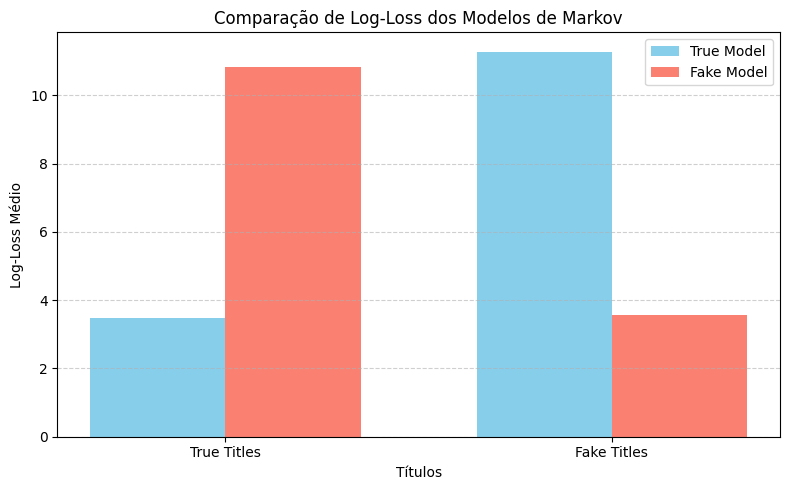

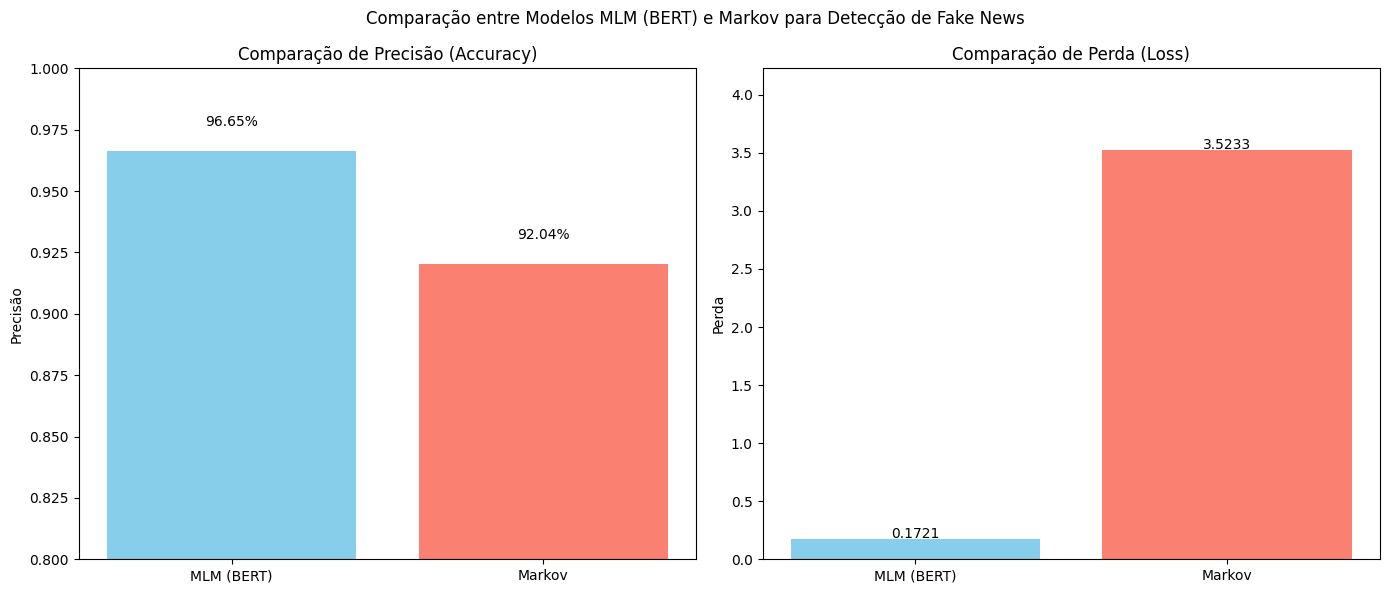

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calcula os log-loss usando a função definida anteriormente (com bigramas e smoothing)
loss_true_on_true_model = calculate_log_loss(model_true, titles_true)
loss_fake_on_true_model = calculate_log_loss(model_true, titles_fake)
loss_true_on_fake_model = calculate_log_loss(model_fake, titles_true)
loss_fake_on_fake_model = calculate_log_loss(model_fake, titles_fake)

# Média dos losses em classificações corretas (usado como "loss do modelo Markov")
markov_loss = (loss_true_on_true_model + loss_fake_on_fake_model) / 2

# === GRÁFICO 1: Comparação de Log-Loss nos Modelos de Markov ===
labels = ['True Titles', 'Fake Titles']
true_model_losses = [loss_true_on_true_model, loss_fake_on_true_model]
fake_model_losses = [loss_true_on_fake_model, loss_fake_on_fake_model]

x = range(len(labels))
bar_width = 0.35

plt.figure(figsize=(8, 5))
plt.bar([i - bar_width/2 for i in x], true_model_losses, bar_width, label='True Model', color='skyblue')
plt.bar([i + bar_width/2 for i in x], fake_model_losses, bar_width, label='Fake Model', color='salmon')

plt.xlabel('Títulos')
plt.ylabel('Log-Loss Médio')
plt.title('Comparação de Log-Loss dos Modelos de Markov')
plt.xticks(x, labels)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

final_val_loss_mlm = history_finetuned.history['val_loss'][-1]
final_val_acc_mlm = history_finetuned.history['val_accuracy'][-1]

# === GRÁFICO 2: Comparação Markov vs BERT (com loss real do Markov) ===
models = ['MLM (BERT)', 'Markov']
accuracy = [final_val_acc_mlm, acc]
loss = [final_val_loss_mlm, markov_loss]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy
ax1.bar(models, accuracy, color=['skyblue', 'salmon'])
ax1.set_title('Comparação de Precisão (Accuracy)')
ax1.set_ylabel('Precisão')
ax1.set_ylim(0.8, 1.0)
for i, v in enumerate(accuracy):
    ax1.text(i, v + 0.01, f"{v*100:.2f}%", ha='center')

# Loss
ax2.bar(models, loss, color=['skyblue', 'salmon'])
ax2.set_title('Comparação de Perda (Loss)')
ax2.set_ylabel('Perda')
ax2.set_ylim(0, max(loss)*1.2)
for i, v in enumerate(loss):
    ax2.text(i, v + 0.01, f"{v:.4f}", ha='center')

plt.suptitle('Comparação entre Modelos MLM (BERT) e Markov para Detecção de Fake News')
plt.tight_layout()
plt.show()
